# Investigate "Data Scientist Job market  

### Import all necessary libraries 

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

%matplotlib inline

### Load dataset and get some first information about it

Dataset "Data Scientist Job Market in the U.S." obtained from Kaggle: 
https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us#alldata.csv

In [2]:
df = pd.read_csv('alldata.csv',sep = ',')
df.head()

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"


In [3]:
print('Dataset has a schape of {} rows and {} columns '.format(df.shape[0], df.shape[1]))

Dataset has a schape of 6964 rows and 5 columns 


### Data preparation 

In [4]:
# Remove information about "Dealmoon" company since the job post is in chinese
df = df.loc[df['company'] != 'Dealmoon']

# Get only the city/state name from the location
df['location_city'] = df['location'].str.split(',').str[0]
df['location_state'] = df['location'].str.split(',').str[1].str[1:3]

# Rename the columns in order to be able to use them later
df.rename(columns = {'company':'company_name','position':'position_name','location':'location_name'}, inplace = True)

# Lower case of all characters in "description" column
df['description'] = df['description'].astype(str).str.lower()


### Data extraction from "Description" column: 
    1. Expected work experience

In [5]:
experience = []

# loop through every single job description
for i in range(df.shape[0]):
    s = ''
    temp_list = []
    res = np.nan
    
    # regular expression that searches a pattern: "xx", "x-x" or 'x+' year(s)
    pattern = re.compile(r'\d\d?\d?\+?(-\d)?\s[a-z]ears?')
    match = pattern.finditer(df.iloc[i,2])
    
    # loop through every match and get a first number (minimum years expectation) 
    for m in match:
        t = m.group(0)
        if t[:1].isdigit() == True: 
            val = int(t[:1])
        if t[:2].isdigit() == True: 
            val = int(t[:2])
        if t[:3].isdigit() == True: 
            val = int(t[:3])    
        temp_list.append(val)
    # calculate a mean expectation from all matches per job post
    res = np.mean(temp_list)
    
    # consider only results < 15 years --> some descriptions mention age of the company (like: "our company's 100 years of..."), so need to avoid it
    if res > 15:
        res = np.nan
    
    experience.append(res)

df['years_experience'] = experience

C:\Users\vital\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\vital\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2. Information about programming languages R and C (need special treatment since the name consists of a single letter)

In [6]:
r = []
c = []

# loop through every single job description
for i in range(df.shape[0]):
    
    # regular expression that searces "r" and counts it mentions in each job description
    pattern_r = re.compile(r'(\s|\,|\()r(\.|,|\\|\s|\))')
    match_r = pattern_r.finditer(df.iloc[i,2])
    r.append(len(tuple(match_r)))
    
    # regular expression that searces "c" and counts it mentions in each job description
    pattern_c = re.compile(r'(\s|\,|\()(c)(\.|,|\\|\s|\))')
    match_c = pattern_c.finditer(df.iloc[i,2])
    c.append(len(tuple(match_c)))
    
df['R_language'] = r
df['C_language'] = c

3. Create a "Bag of Words" from "description" column (code adopted from amazing NLP tutorial: https://github.com/adashofdata/nlp-in-python-tutorial)

In [7]:
# define a cleaning function
def clean_text(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', ' ', text)

    return text

# clean a "description" column
data_clean = pd.DataFrame(df['description'].apply(lambda x: clean_text(x)))

# create a bag of words
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean['description'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index

# append previously created columns
data_all_words = pd.concat([df[['company_name','position_name','location_city','location_state','years_experience','R_language','C_language']],data_dtm], axis = 1)
data_all_words.head()

,company_name,position_name,location_city,location_state,years_experience,R_language,C_language,aa,aaa,aaai,...,équipe,équipes,études,êtes,øptimus,œbig,œyesâ,ﬁeld,ﬁndings,ﬁtness
0,ALS TDI,Development Director,Atlanta,GA,6.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Hexagon Lavish,An Ostentatiously-Excitable Principal Research...,Atlanta,GA,5.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Xpert Staffing,Data Scientist,Atlanta,GA,5.000000,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Operation HOPE,Data Analyst,Atlanta,GA,5.666667,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Emory University,Assistant Professor -TT - Signal Processing & ...,Atlanta,GA,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data exploration 

### Explore demand in Data Experts: Top Companies 

##### In this section I want to see which companies posted the most job vacancies. Top 30 companies are plotted. These 30 companies will be further named as "Top 30".

In [27]:
top_30_share = int(100*(np.sum(df['company_name'].value_counts(ascending = False)[:30].values) / df.shape[0]))
print('Total number of companies is {}. 30 companies with the highest number of job placements share a {} % of all job postings.'.format(len(df['company_name'].unique()), top_30_share ))

Total number of companies is 2213. 30 companies with the highest number of job placements share a 26 % of all job postings.


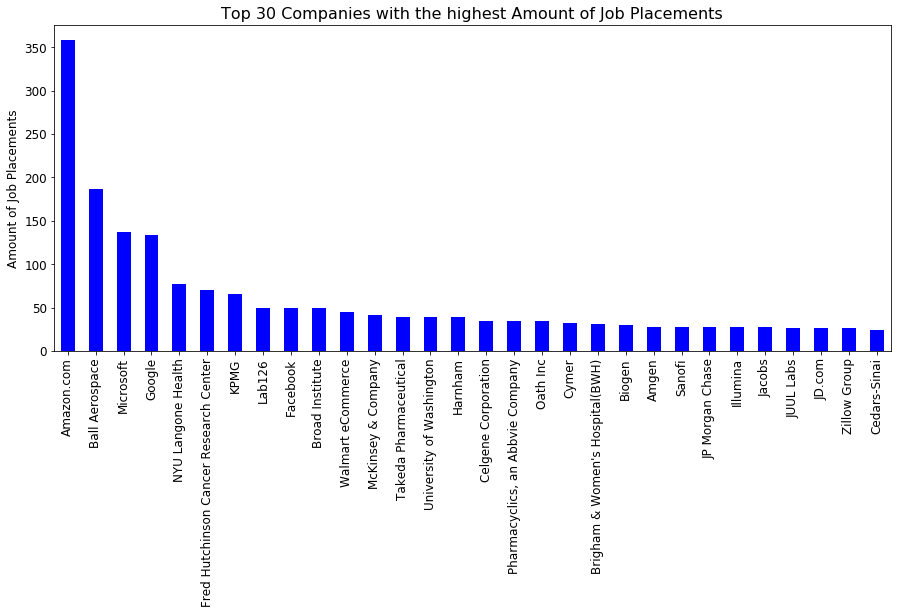

In [29]:
# Visualise a statistics about companies
fig, axes = plt.subplots(figsize = (15,6))
df['company_name'].value_counts(ascending = False)[:30].plot(kind = 'bar', color = 'blue', fontsize = 12, ax = axes)
axes.set_ylabel('Amount of Job Placements', fontsize = 12)
axes.set_title('Top 30 Companies with the highest Amount of Job Placements', fontsize = 16);

#### Conclusion: 
**Amazon** is clearly number one with 358 ads, which is almost 2 times more than the **Ball Aerospace** (Rank2). **Microsoft and Google** are on place 3 and 4 with >100 Ads.  

### Explore demand in Data Experts: Top Cities

##### In this section I would like to know which US cities lack data experts the most. It is also interesting to know the share of "Top 30" companies in each city. 

Total number of cities in database is 92


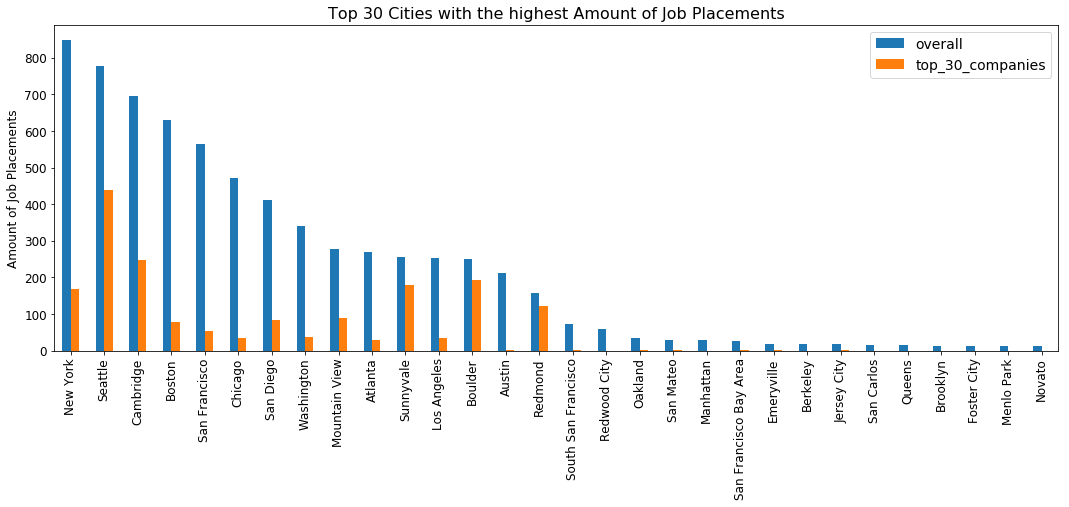

In [9]:
# visualise a statistics about cities
top_30_companies = df['company_name'].value_counts(ascending = False)[:30].index
df_city = pd.DataFrame({'overall':df['location_city'].value_counts()})
df_city_top_30 =  pd.DataFrame({'top_30_companies':df.loc[df['company_name'].isin(top_30_companies),'location_city'].value_counts()})

fig, axes = plt.subplots(figsize = (18,6))
pd.concat([df_city,df_city_top_30], axis = 1,sort = False).sort_values('overall',ascending = False)[:30].plot(kind = 'bar', fontsize = 12, ax = axes)
axes.set_ylabel('Amount of Job Placements', fontsize = 12)
axes.set_title('Top 30 Cities with the highest Amount of Job Placements', fontsize = 16);
axes.legend(fontsize = 14);
print('Total number of cities in database is {}'.format(len(df['location_city'].unique())))

#### Conclusion: 
**New York** gives more opportunities for Data Experts to find a job with more than 800 job vacancies. **Seatle, Cambridge, Boston and San-Fracisco** are on places 2-5. **New-York** together with **Boston, San-Francisco and Chicago** has a very low share of "Top 30" companies (orange bar), which means that there are many companies searching for Data Experts. **Seatle** on the contrary has a high share of "Top 30" companies (mainly due to Amazon), which means if you do not have luck by Amazon, your chances to get job in this city are not very high.

### Explore demand in Data Experts: Top States

##### In this section I would like to know which US states require data experts the most. It is also interesting to know the share of "Top 30" companies in each state. 

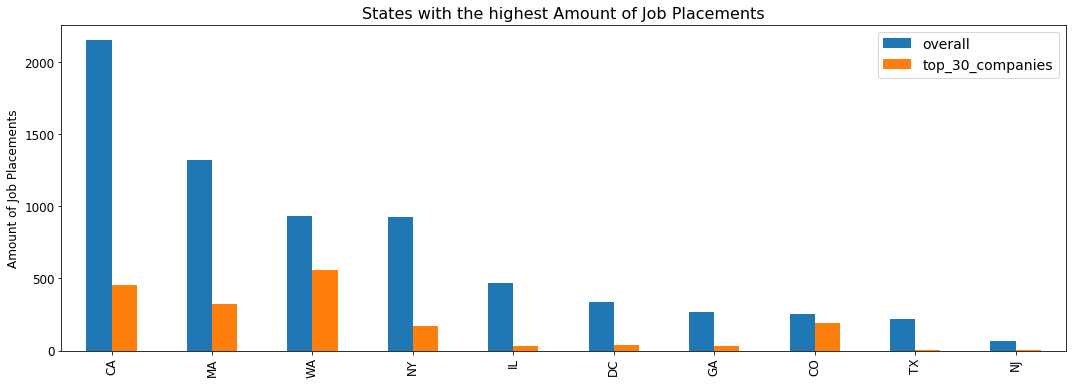

In [10]:
# visualise a statistics about states
top_30_companies = df['company_name'].value_counts(ascending = False)[:30].index
df_state = pd.DataFrame({'overall':df['location_state'].value_counts()})
df_state_top_30 =  pd.DataFrame({'top_30_companies':df.loc[df['company_name'].isin(top_30_companies),'location_state'].value_counts()})

fig, axes = plt.subplots(figsize = (18,6))
pd.concat([df_state,df_state_top_30], axis = 1, sort = False).sort_values('overall',ascending = False)[:30].plot(kind = 'bar', fontsize = 12, ax = axes)
axes.set_ylabel('Amount of Job Placements', fontsize = 12)
axes.set_title('States with the highest Amount of Job Placements', fontsize = 16);
axes.legend(fontsize = 14);

#### Conclusion: 
**Callifornia** is a clear leader. This state lacks >2100 experts. Apprx. 25% of positions come from "Top 30" companies, so there are plenty of rather small companies searching for data experts. 

### Explore requirements / expectations on Data Experts 

##### In this section I would like to investigate the US companies requirements on the years of experience. 

Statics of required experience
count    4470.000000
mean        4.458977
std         2.697547
min         0.000000
25%         2.500000
50%         4.000000
75%         5.000000
max        15.000000
Name: years_experience, dtype: float64


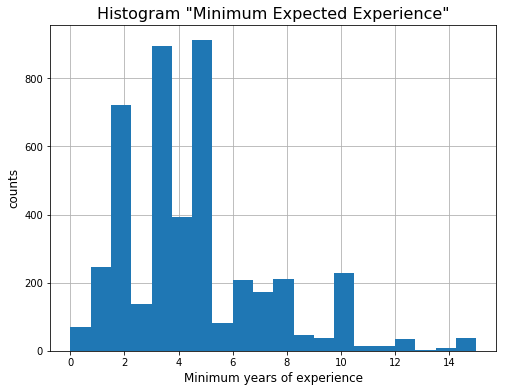

In [35]:
# Years of experience
print('Statics of required experience')
print(df['years_experience'].describe())
fig, axes = plt.subplots(figsize = (8,6))
df['years_experience'].hist(bins = 20, ax =axes, zorder = 3)
axes.grid(zorder = 0)
axes.set_xlabel('Minimum years of experience', fontsize = 12)
axes.set_ylabel('counts', fontsize = 12)
axes.set_title('Histogram "Minimum Expected Experience"', fontsize = 16);

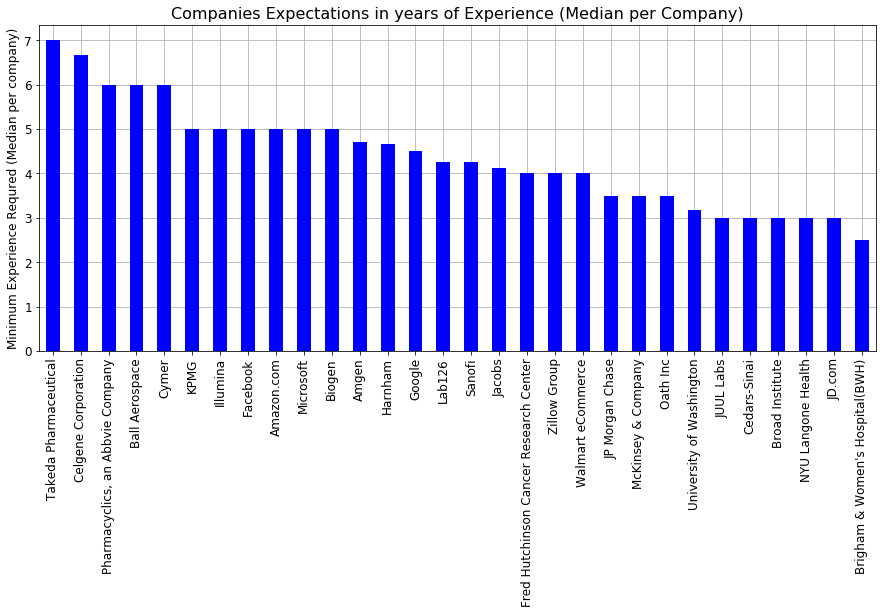

In [12]:
fig, axes = plt.subplots(figsize = (15,6))
df.loc[df['company_name'].isin(top_30_companies)].groupby('company_name')['years_experience'].median().sort_values(ascending = False).plot(kind = 'bar', zorder = 3, fontsize = 12, color = 'blue', ax = axes)
axes.grid(zorder = 0)
axes.set_ylabel('Minimum Experience Requred (Median per company)', fontsize = 12) 
axes.set_xlabel('')
axes.set_title('Companies Expectations in years of Experience (Median per Company)', fontsize = 16);

#### Conclusion: 
* the descriptive statistics showed that the median lies around 4 Years. The mean is slightly higher (4.46 Years). This is due to outliers that belong to rather managment positions. Histogram show 4 clear peaks: 2 years, 3-5 years, 6-8 years and 10 years of experience that probably indicate the expertise levels. 
* Which companies require the largest experience? It is interesting that top 3 companies are all from pharmaceutical field with the expectation of >=6 years of experience. The IT giants like Amazon, Google, Microsoft require in median 4 years of experience.  

## Analysing Expectation on Technical Skills (Programming Languages, Tools, Databases) 

##### In this section I would like to investigate the companies requirements on technical skills: which programming languages, tools should ideal candidate know.

In [22]:
# function that creates summary table over all companies and given tools
def get_programming_lang (programming_list, data, col):
    company = []
    prog_lang = []
    
    data_comp_num = data[col].value_counts()
    
    for i in programming_list:
        if i in data.columns:
            prog_lang.append(i)
    
    res =  pd.concat([data.groupby(col)[prog_lang].sum(),data_comp_num],sort = False,axis = 1)
    
    # get a normalized value per company and tool --> how often each tool comes in every single posting
    for i in res.columns[:-1]:
        col_name = i + '_norm'
        res[col_name] = res[i] / res[col]
        
    return res

# define a list of programming languages / tools
programming_languages = ['python','java','javascript','sql','php','ruby','excel','tableau','spss','spark','R_language','C_language','hadoop','scala','aws']

# define a database that consists of the data from top30 companies
data_all_words_top30 = data_all_words.loc[data_all_words['company_name'].isin(top_30_companies)]


res = get_programming_lang(programming_languages,data_all_words_top30, 'company_name')
res.head()

,python,java,javascript,sql,php,ruby,excel,tableau,spss,spark,...,ruby_norm,excel_norm,tableau_norm,spss_norm,spark_norm,R_language_norm,C_language_norm,hadoop_norm,scala_norm,aws_norm
Amazon.com,262,217,36,109,0,34,45,33,3,55,...,0.094972,0.125698,0.092179,0.00838,0.153631,0.265363,0.134078,0.150838,0.072626,0.921788
Amgen,0,0,0,0,0,0,3,2,0,0,...,0.000000,0.107143,0.071429,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ball Aerospace,5,3,0,7,0,8,14,0,0,0,...,0.042781,0.074866,0.000000,0.00000,0.000000,0.000000,0.069519,0.000000,0.000000,0.000000
Biogen,5,0,0,1,0,0,4,0,0,0,...,0.000000,0.133333,0.000000,0.00000,0.000000,0.133333,0.033333,0.000000,0.000000,0.033333
Brigham & Women's Hospital(BWH),3,2,0,0,0,0,4,0,0,0,...,0.000000,0.129032,0.000000,0.00000,0.000000,0.064516,0.161290,0.000000,0.000000,0.000000


Text(0, 0.5, 'Relative occurrence of the tool in ad')

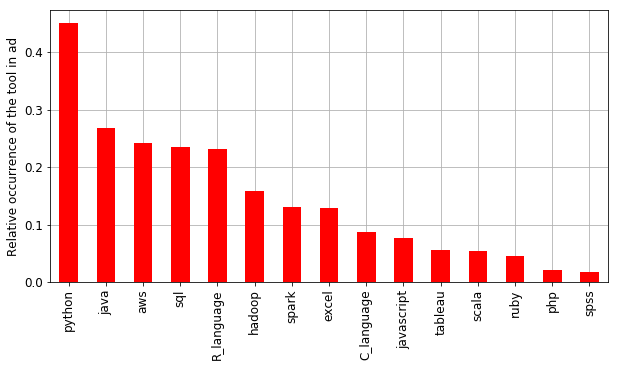

In [23]:
# get the rank of the tools 
pl = res.loc[:,programming_languages].sum() / res['company_name'].sum()
fig, axes = plt.subplots(figsize = (10,5))
pl.sort_values(ascending = False).plot(kind = 'bar', fontsize = 12, color = 'red', ax = axes, zorder = 3)
axes.grid(zorder = 0)
axes.set_ylabel('Relative occurrence of the tool in ad', fontsize = 12)

In [24]:
# make some company names shorter for visualisation purposes
res.rename(index = {'Fred Hutchinson Cancer Research Center':'F.Hutchinson RC',
                    "Brigham & Women's Hospital(BWH)":'BWH',
                   "McKinsey & Company":"McKinsey",
                   "Pharmacyclics, an Abbvie Company":'Pharmacyclics',
                   "University of Washington":'U.Washington',
                   "Walmart eCommerce":'Walmart'}, inplace = True)

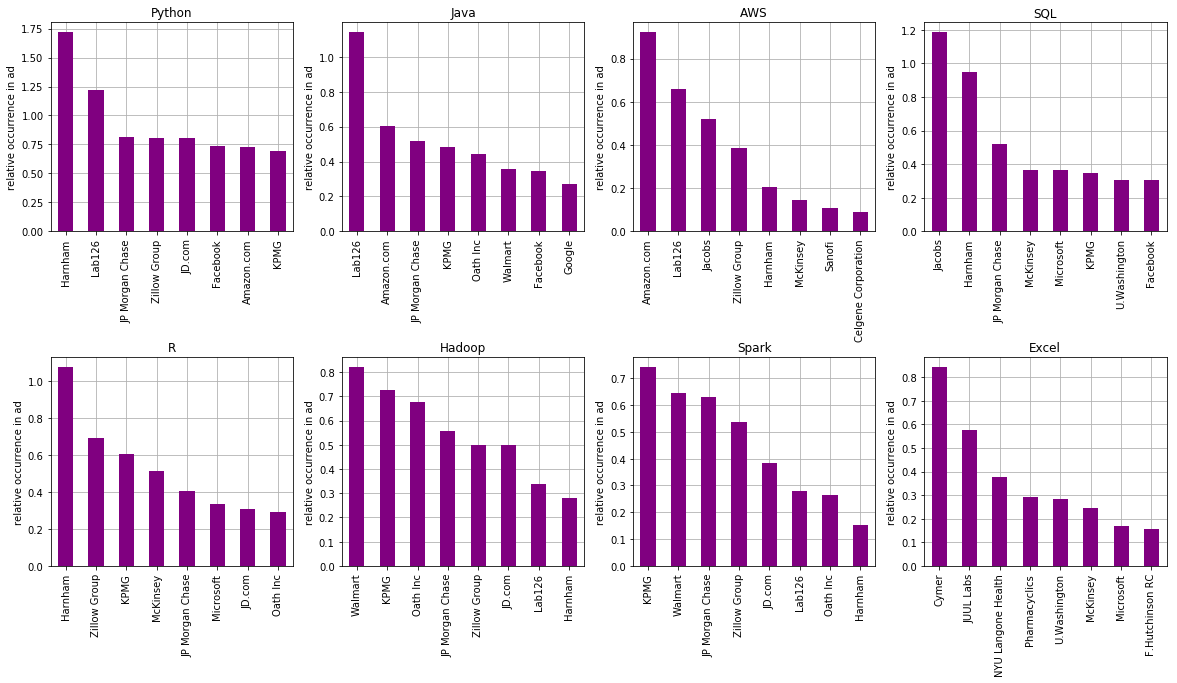

In [25]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (20,10))
plt.subplots_adjust(hspace = 0.6)

def plot_tool(col, tit, r, c):
    res[col].sort_values(ascending = False)[:8].plot(kind = 'bar', color = 'purple',zorder = 3, ax = axes[r,c])
    axes[r,c].set_title(tit)
    axes[r,c].set_ylabel('relative occurrence in ad')
    axes[r,c].grid(zorder = 0)

plot_tool('python_norm','Python',0, 0)
plot_tool('java_norm','Java',0, 1)
plot_tool('aws_norm','AWS',0, 2)
plot_tool('sql_norm','SQL',0, 3)
plot_tool('R_language_norm','R',1, 0)
plot_tool('hadoop_norm','Hadoop',1, 1)
plot_tool('spark_norm','Spark',1, 2)
plot_tool('excel_norm','Excel',1, 3)


#### Conclusion: 
1. The technical requirement number one is clearly **Python**, apprx. 44% of all ads contain Python in the requirements. **Java and R**
are also nice to know, since almost every 4th add require them. **AWS**, **SQL** and **Hadoop** are also among leaders (places 3,4 and 6 respectively), so the expertise in databases and cloud systems is a must. 
2. Technical skills related to companies: **Python** - Harnham and Lab126 mention Python >1 time in their ads; **Java** - all ads from Lab126 and 60% Amazon vacancies require Java; **AWS** - surprisingly very common word for Amazon ads; **SQL** - Jacobs and Harnham mention SQL in every vacancy text; **R** - Harnham requires it for every position; **Hadoop & Spark** - Walmart and KPMG are in demand on experts in Big Data; **Excel** - is required by Cymer, JUUL Labs and NYU Langone Health. 

### Analyse job descriptions using WordClouds --> get some insights analysing companies most used words

##### In this section I would like to know which words the companies use the most in their ads. This could probably help to get some feeling about their culture, focus and spirit.

In [17]:
# define a dataset to analyse
data_clean_comp = pd.concat([df['company_name'],data_clean], axis = 1)
data_clean_comp.head()

,company_name,description
0,ALS TDI,development director als therapy development i...
1,The Hexagon Lavish,job description the road that leads to accomp...
2,Xpert Staffing,growing company located in the atlanta ga area...
3,Operation HOPE,department program operationsposition location...
4,Emory University,description the emory university department of...


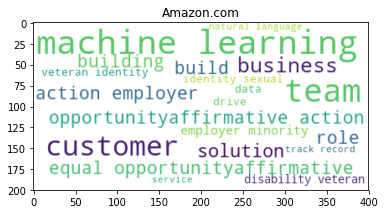

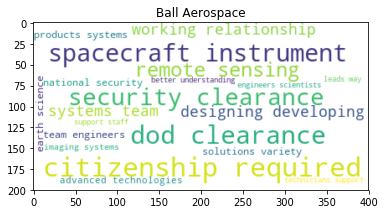

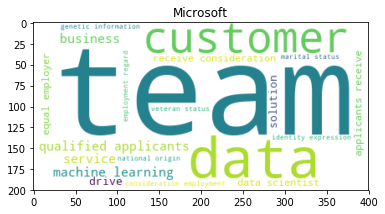

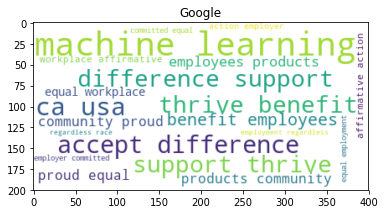

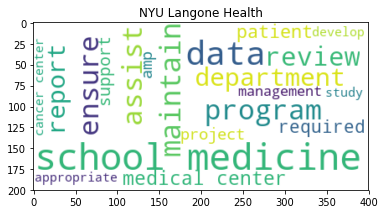

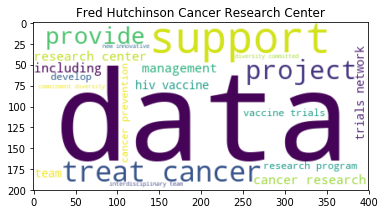

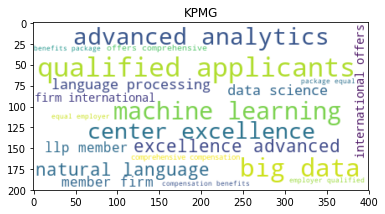

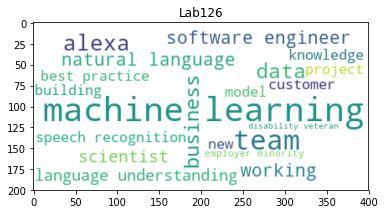

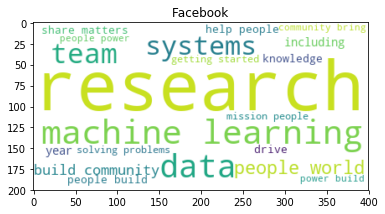

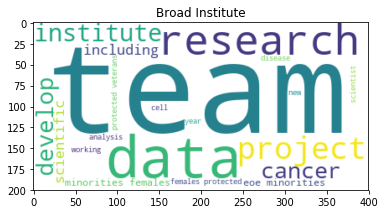

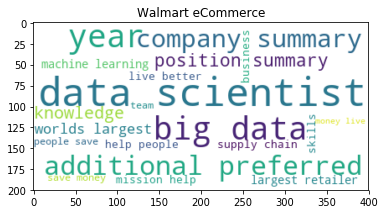

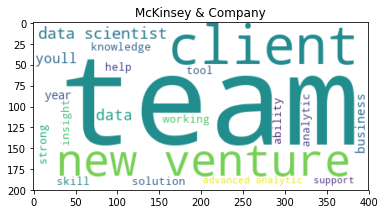

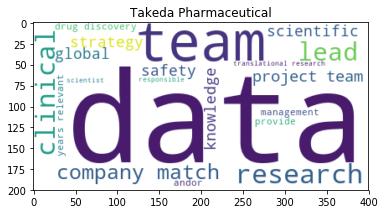

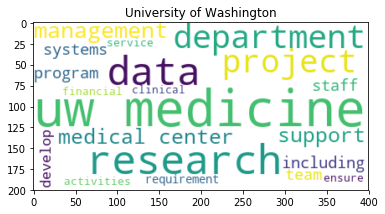

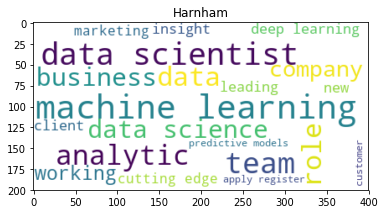

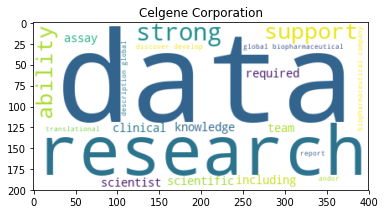

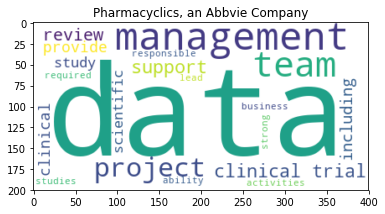

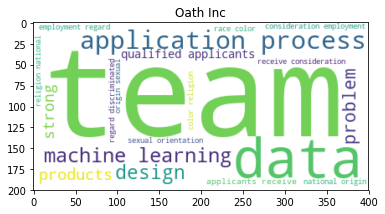

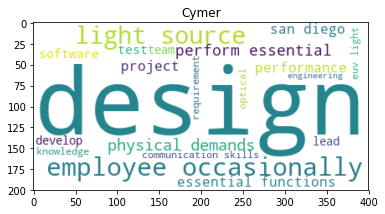

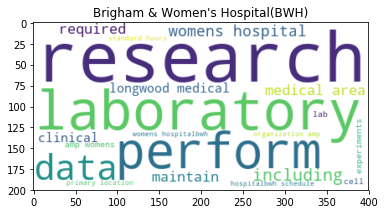

In [18]:
# Create WordCloud Object

# Define stop words
stop_words = text.ENGLISH_STOP_WORDS
stop_words_add = ['experience','computer','basic','qualifications','development','product','opportunity','opportunities','work','gender',
                 'related','technical','dont','just','celebrate']
comp_names = ['amazon','ball','aerospace','microsoft','google','nyu','langone','fred','hutchinson','kpmg','lab126','broad','facebook','mckinsey',
             'washington','walmart','ecommerce','takeda','harnham','oath','inc','pharmacyclics','abbvie','celgene','corporation','cymer',
             'brigham','bwh']

stop_words1 = stop_words.union(stop_words_add,comp_names)

# WordCloud object
wc = WordCloud(stopwords=stop_words1, background_color="white", 
               max_font_size=150, random_state=42, max_words=20)

# Function to create WordCloud  
def gen_word_cloud(company, wc):
    company_clean = data_clean_comp.loc[data_clean_comp['company_name'] == company,:]
    
    text_all = ''
    for i in company_clean['description']:
        text_all = text_all + str(i)
    
    wc.generate(text_all)
    
    plt.imshow(wc, interpolation="bilinear")
    plt.title(company)
    plt.show()    

# Loop over top20 companies and plot WorldCloud
for i in df['company_name'].value_counts(ascending = False).index[0:20]:
    gen_word_cloud(i,wc)

#### Some impressions:
* **Amazon**: focus on machine learning
* **Microsoft**: team work is very important
* **Ball Aerospace**: spacecraft instruments and remote sensing, but only for US citizens
* **Google**: focus on machine learning and its employee
* **Facebook**: focus on research and machine learning. Large scale thinking: world, people.
* **Walmart**: focus on big data (as largest retailer)